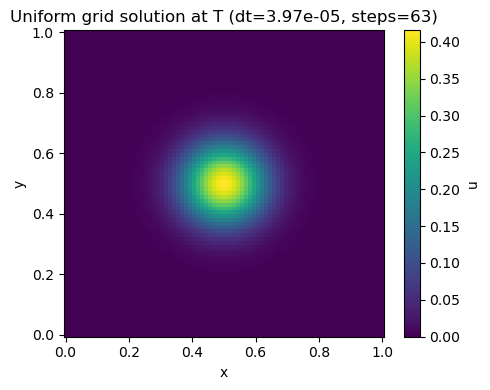

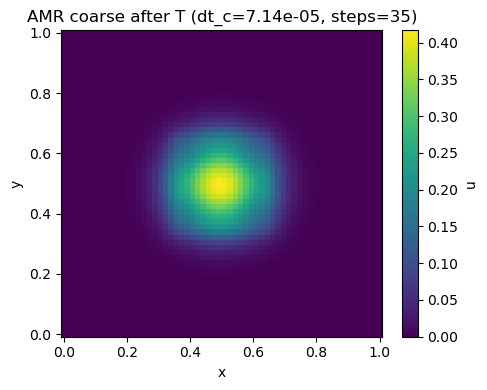

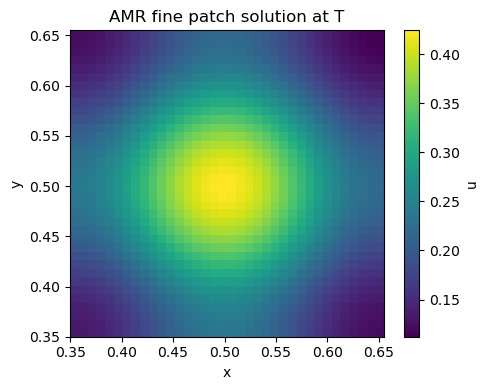

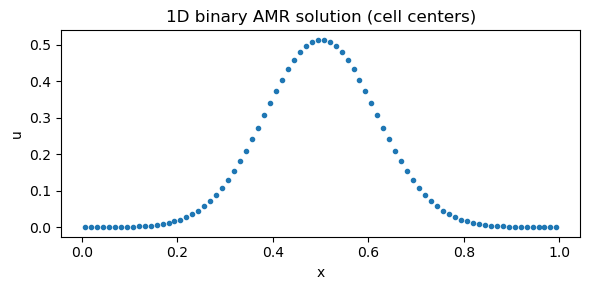

Uniform 2D: nx,ny = 80 80 ; final dt 3.968253968253968e-05 nsteps 63
Block-AMR coarse: nx,ny = 60 60 ; fine patch nx,ny = 36 36
Binary AMR 1D: final number of cells 80 dt 3.875968992248062e-05 nsteps 129


In [ ]:
# 2D uniform diffusion + 2D block-AMR (one refinement level) + 1D "quadtree-like" (binary) adaptive example
# This notebook runs small demos for each method and shows plots.
# It is meant as clear, runnable code you can copy into a script or Jupyter notebook.
# Notes:
# - Explicit forward Euler is used for simplicity (stable if dt <= h^2/(4*D) in 2D).
# - Block-AMR implements a single rectangular fine patch with subcycling in time (factor=2).
# - Quadtree example is shown in 1D as a binary adaptive grid for clarity; extension to 2D is discussed in comments.

import numpy as np
import matplotlib.pyplot as plt


# ---------- Utilities ----------
def gaussian_2d(x, y, x0=0.5, y0=0.5, sigma=0.08):
    return np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma**2))


def plot_2d(u, x, y, title=""):
    X, Y = np.meshgrid(x, y, indexing="xy")
    plt.figure(figsize=(5, 4))
    plt.pcolormesh(X, Y, u.T, shading="auto")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.colorbar(label="u")
    plt.tight_layout()
    plt.show()


# ---------- 1) Plain 2D uniform-grid explicit diffusion ----------
def diffuse_2d_uniform(nx=100, ny=100, D=1.0, T=0.01, plot_every=None):
    # Domain [0,1]x[0,1]
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    hx = x[1] - x[0]
    hy = y[1] - y[0]
    hmin = min(hx, hy)
    # Stability limit for explicit 2D: dt <= h^2/(4*D) approximately (conservative)
    dt = 0.25 * hmin * hmin / D
    nsteps = int(np.ceil(T / dt))
    dt = T / nsteps

    # initial condition: centered Gaussian
    X, Y = np.meshgrid(x, y, indexing="xy")
    u = gaussian_2d(X, Y, 0.5, 0.5, sigma=0.06)

    for n in range(nsteps):
        # zero-flux (Neumann) BCs implemented by mirroring
        u_xx = np.zeros_like(u)
        u_yy = np.zeros_like(u)
        u_xx[1:-1, :] = (u[2:, :] - 2 * u[1:-1, :] + u[0:-2, :]) / hx**2
        u_yy[:, 1:-1] = (u[:, 2:] - 2 * u[:, 1:-1] + u[:, :-2]) / hy**2
        # boundaries (Neumann, zero gradient): second derivative approximated with mirror
        u_xx[0, :] = (
            u[1, :] - 2 * u[0, :] + u[1, :]
        ) / hx**2  # u[-1] mirrored => u[1]
        u_xx[-1, :] = (u[-2, :] - 2 * u[-1, :] + u[-2, :]) / hx**2
        u_yy[:, 0] = (u[:, 1] - 2 * u[:, 0] + u[:, 1]) / hy**2
        u_yy[:, -1] = (u[:, -2] - 2 * u[:, -1] + u[:, -2]) / hy**2

        u += dt * D * (u_xx + u_yy)
        if plot_every and (n % plot_every == 0):
            plot_2d(u, x, y, title=f"Uniform 2D diffusion t={dt*(n+1):.4f}")
    return x, y, u, dt, nsteps


# Run uniform demo
x_u, y_u, u_u, dt_u, nsteps_u = diffuse_2d_uniform(
    nx=80, ny=80, D=1.0, T=0.0025, plot_every=None
)
plot_2d(
    u_u,
    x_u,
    y_u,
    title=f"Uniform grid solution at T (dt={dt_u:.2e}, steps={nsteps_u})",
)

# ---------- 2) 2D Block-AMR with single rectangular fine patch ----------
# Approach:
# - Coarse grid covers domain [0,1]x[0,1]
# - A rectangular fine patch overlapping a region of interest is defined with refinement factor r=2
# - Fine patch uses smaller h and dt (subcycled by factor r^2 approximately for diffusion; we use r^2 for stability)
# - At each coarse step: advance coarse by dt_c; inside that, advance fine r^2 substeps with dt_f = dt_c / r^2
# - After fine advances, inject (average) fine to coarse cells in the overlap (simple conservative restriction)
# Notes: This is a simplified toy AMR to demonstrate the idea; production AMR has flux corrections etc.


class BlockAMR2D:
    def __init__(
        self,
        nx_coarse=40,
        ny_coarse=40,
        D=1.0,
        refine_factor=2,
        fine_patch_bounds=(0.35, 0.65, 0.35, 0.65),
    ):
        self.nx_c = nx_coarse
        self.ny_c = ny_coarse
        self.D = D
        self.rf = refine_factor
        self.xc = np.linspace(0, 1, self.nx_c)
        self.yc = np.linspace(0, 1, self.ny_c)
        self.hx_c = self.xc[1] - self.xc[0]
        self.hy_c = self.yc[1] - self.yc[0]
        # define fine patch in physical coords (xmin,xmax,ymin,ymax)
        self.f_bounds = fine_patch_bounds
        xmin, xmax, ymin, ymax = fine_patch_bounds
        # compute fine grid indices overlapping
        # choose fine grid so that its cell centers align with coarse grid via integer refinement
        # number of fine cells per coarse cell is rf
        self.nx_f = int(np.ceil((xmax - xmin) / (self.hx_c / self.rf)))
        self.ny_f = int(np.ceil((ymax - ymin) / (self.hy_c / self.rf)))
        # fine grid spacing
        self.hx_f = self.hx_c / self.rf
        self.hy_f = self.hy_c / self.rf
        # physical fine grid axes centered to cover bounds approximately
        self.xf = np.linspace(
            xmin + 0.5 * self.hx_f,
            xmin + (self.nx_f - 0.5) * self.hx_f,
            self.nx_f,
        )
        self.yf = np.linspace(
            ymin + 0.5 * self.hy_f,
            ymin + (self.ny_f - 0.5) * self.hy_f,
            self.ny_f,
        )
        # arrays
        self.u_c = np.zeros((self.nx_c, self.ny_c))
        self.u_f = np.zeros((self.nx_f, self.ny_f))

    def init_gaussian(self, x0=0.5, y0=0.5, sigma=0.06):
        Xc, Yc = np.meshgrid(self.xc, self.yc, indexing="xy")
        self.u_c = gaussian_2d(Xc, Yc, x0, y0, sigma)
        Xf, Yf = np.meshgrid(self.xf, self.yf, indexing="xy")
        self.u_f = gaussian_2d(Xf, Yf, x0, y0, sigma)

    def step_coarse(self, dt):
        # explicit update on coarse grid with Neumann BCs
        u = self.u_c
        nx, ny = u.shape
        ux_xx = np.zeros_like(u)
        uy_yy = np.zeros_like(u)
        hx = self.hx_c
        hy = self.hy_c
        ux_xx[1:-1, :] = (u[2:, :] - 2 * u[1:-1, :] + u[0:-2, :]) / hx**2
        uy_yy[:, 1:-1] = (u[:, 2:] - 2 * u[:, 1:-1] + u[:, :-2]) / hy**2
        ux_xx[0, :] = (u[1, :] - 2 * u[0, :] + u[1, :]) / hx**2
        ux_xx[-1, :] = (u[-2, :] - 2 * u[-1, :] + u[-2, :]) / hx**2
        uy_yy[:, 0] = (u[:, 1] - 2 * u[:, 0] + u[:, 1]) / hy**2
        uy_yy[:, -1] = (u[:, -2] - 2 * u[:, -1] + u[:, -2]) / hy**2
        self.u_c = u + dt * self.D * (ux_xx + uy_yy)

    def step_fine(self, dtf):
        # explicit fine update
        u = self.u_f
        nx, ny = u.shape
        ux_xx = np.zeros_like(u)
        uy_yy = np.zeros_like(u)
        hx = self.hx_f
        hy = self.hy_f
        ux_xx[1:-1, :] = (u[2:, :] - 2 * u[1:-1, :] + u[0:-2, :]) / hx**2
        uy_yy[:, 1:-1] = (u[:, 2:] - 2 * u[:, 1:-1] + u[:, :-2]) / hy**2
        ux_xx[0, :] = (u[1, :] - 2 * u[0, :] + u[1, :]) / hx**2
        ux_xx[-1, :] = (u[-2, :] - 2 * u[-1, :] + u[-2, :]) / hx**2
        uy_yy[:, 0] = (u[:, 1] - 2 * u[:, 0] + u[:, 1]) / hy**2
        uy_yy[:, -1] = (u[:, -2] - 2 * u[:, -1] + u[:, -2]) / hy**2
        self.u_f = u + dtf * self.D * (ux_xx + uy_yy)

    def inject_fine_to_coarse(self):
        # conservative restriction: average fine cells falling into each coarse cell
        xmin, xmax, ymin, ymax = self.f_bounds
        # coarse indices covering patch
        i0 = int(np.searchsorted(self.xc, xmin) - 1)
        j0 = int(np.searchsorted(self.yc, ymin) - 1)
        # clamp
        i0 = max(0, i0)
        j0 = max(0, j0)
        # map each fine cell to a coarse cell index
        # for simplicity, use nearest coarse center mapping
        for ii in range(self.nx_f):
            for jj in range(self.ny_f):
                x = self.xf[ii]
                y = self.yf[jj]
                ic = int(np.argmin(np.abs(self.xc - x)))
                jc = int(np.argmin(np.abs(self.yc - y)))
                # simple overwrite average (better: accumulate and divide later - here patch aligned so overwrite is ok)
                self.u_c[ic, jc] = 0.5 * (self.u_c[ic, jc] + self.u_f[ii, jj])

    def run(self, T=0.002):
        # choose dt based on stability for coarse grid
        hx = self.hx_c
        hy = self.hy_c
        dt_c = 0.25 * min(hx * hx, hy * hy) / self.D
        # subcycling factor: rf^2 for diffusion stability
        subcycle = self.rf * self.rf
        dt_f = dt_c / subcycle
        nsteps = int(np.ceil(T / dt_c))
        dt_c = T / nsteps
        dt_f = dt_c / subcycle
        for n in range(nsteps):
            # advance fine with subcycling
            for k in range(subcycle):
                self.step_fine(dt_f)
            # inject fine into coarse
            self.inject_fine_to_coarse()
            # advance coarse one coarse step
            self.step_coarse(dt_c)
        return dt_c, nsteps


# Run BlockAMR demo
amr = BlockAMR2D(
    nx_coarse=60,
    ny_coarse=60,
    D=1.0,
    refine_factor=2,
    fine_patch_bounds=(0.35, 0.65, 0.35, 0.65),
)
amr.init_gaussian(x0=0.5, y0=0.5, sigma=0.06)
dt_c, nsteps = amr.run(T=0.0025)
plot_2d(
    amr.u_c,
    amr.xc,
    amr.yc,
    title=f"AMR coarse after T (dt_c={dt_c:.2e}, steps={nsteps})",
)
plot_2d(amr.u_f, amr.xf, amr.yf, title="AMR fine patch solution at T")

# ---------- 3) 1D binary 'quadtree-like' adaptive grid (toy quadtree in 1D) ----------
# This implements a binary tree adaptive finite-volume scheme in 1D for u_t = D u_xx.
# Cells are stored as a list of varying sizes. Fluxes between neighbors are computed by harmonic averaging of cell sizes.
# For clarity, we implement a conservative finite-volume explicit update.


class BinaryAMR1D:
    def __init__(self, x0=0.0, x1=1.0, base_cells=64, D=1.0):
        self.x0 = x0
        self.x1 = x1
        self.D = D
        self.base_cells = base_cells
        # start with uniform grid
        xs = np.linspace(x0, x1, base_cells + 1)
        centers = 0.5 * (xs[:-1] + xs[1:])
        widths = xs[1:] - xs[:-1]
        # store cells as list of (center, width, u)
        self.cells = [
            {
                "x": centers[i],
                "dx": widths[i],
                "u": np.exp(-((centers[i] - 0.5) ** 2) / (2 * 0.06**2)),
            }
            for i in range(base_cells)
        ]

    def refine_where_needed(self, grad_tol=50.0):
        # refine cells where |du/dx| > tol
        # compute approximate gradient using neighbor differences
        newcells = []
        N = len(self.cells)
        for i, c in enumerate(self.cells):
            # compute gradient estimate
            ul = self.cells[i - 1]["u"] if i > 0 else self.cells[i]["u"]
            ur = self.cells[i + 1]["u"] if i < N - 1 else self.cells[i]["u"]
            grad = abs((ur - ul) / (c["dx"] * 2))
            if grad > grad_tol and c["dx"] > (
                (self.x1 - self.x0) / (self.base_cells * 8)
            ):  # limit min dx
                # split cell into two
                dx = c["dx"] / 2
                xL = c["x"] - dx / 2
                xR = c["x"] + dx / 2
                newcells.append({"x": xL, "dx": dx, "u": c["u"]})
                newcells.append({"x": xR, "dx": dx, "u": c["u"]})
            else:
                newcells.append(c)
        self.cells = newcells

    def step(self, dt):
        # compute fluxes at interfaces. Use central difference with harmonic averaging of dx.
        N = len(self.cells)
        flux = np.zeros(N + 1)  # interfaces
        # Neumann BCs => zero flux at boundaries
        for i in range(1, N):
            ul = self.cells[i - 1]
            ur = self.cells[i]
            # gradient approximated between cell centers
            dxL = ul["dx"]
            dxR = ur["dx"]
            dist = 0.5 * (dxL + dxR)
            grad = (ur["u"] - ul["u"]) / dist
            # flux = -D * grad
            flux[i] = -self.D * grad
        # update cell averages: du/dt = -(F_{i+1/2}-F_{i-1/2})/dx_i
        for i, c in enumerate(self.cells):
            iL = i
            iR = i + 1
            divF = (flux[iR] - flux[iL]) / c["dx"]
            c["u"] += dt * (-divF)

    def run(self, T=0.01):
        # choose dt based on smallest dx
        min_dx = min(c["dx"] for c in self.cells)
        dt = 0.25 * min_dx**2 / self.D
        nsteps = int(np.ceil(T / dt))
        dt = T / nsteps
        for n in range(nsteps):
            # refine adaptively every few steps
            if n % 5 == 0:
                self.refine_where_needed(grad_tol=40.0)
            # recompute dt if min dx changed
            min_dx = min(c["dx"] for c in self.cells)
            dt = min(dt, 0.25 * min_dx**2 / self.D)
            self.step(dt)
        return dt, nsteps

    def get_solution_arrays(self):
        xs = np.array([c["x"] for c in self.cells])
        us = np.array([c["u"] for c in self.cells])
        dxs = np.array([c["dx"] for c in self.cells])
        return xs, us, dxs


# Run BinaryAMR1D demo
amr1d = BinaryAMR1D(base_cells=80, D=1.0)
dt1, n1 = amr1d.run(T=0.005)
xs, us, dxs = amr1d.get_solution_arrays()

plt.figure(figsize=(6, 3))
plt.plot(xs, us, marker="o", linestyle="none", markersize=3)
plt.xlabel("x")
plt.ylabel("u")
plt.title("1D binary AMR solution (cell centers)")
plt.tight_layout()
plt.show()

# Print summary
print(
    "Uniform 2D: nx,ny =",
    len(x_u),
    len(y_u),
    "; final dt",
    dt_u,
    "nsteps",
    nsteps_u,
)
print(
    "Block-AMR coarse: nx,ny =",
    amr.nx_c,
    amr.ny_c,
    "; fine patch nx,ny =",
    amr.nx_f,
    amr.ny_f,
)
print("Binary AMR 1D: final number of cells", len(xs), "dt", dt1, "nsteps", n1)

# End of demo code.
# Discussion notes:
# - The uniform 2D explicit solver is the simplest and easiest to verify.
# - The Block-AMR example demonstrates the pattern of subcycling and injection/restriction.
#   It is simplified (no flux correction at coarse-fine boundaries, simple overwrite restriction).
# - The 1D binary AMR is a toy quadtree-like adaptive finite-volume solver in 1D. Extending to 2D quadtrees
#   requires careful bookkeeping of neighbors, fluxes across different-size faces, and conservative prolongation/restriction.
# - For production work you'd want implicit or semi-implicit time stepping for diffusion (to avoid small dt),
#   higher-order spatial discretizations, and rigorous flux correction at AMR boundaries (refluxing).